## Discretization drift in Two-Player Games

Copyright 2021 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Figures reproduced
This colab reproduces certain figures (Fig 2, Fig 3 and Figures A.2) from the paper "Discretization drift in Two-Player Games" by by Mihaela Rosca, Yan Wu, Benoit Dherin and
 David G.T. Barrett.


In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import seaborn as sns

In [ ]:
def set_up_fonts():
  sns.reset_orig()

  import matplotlib
  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
set_up_fonts()

In [ ]:
def tree_add(tree1, tree2):
  return np.array(tree1) + np.array(tree2)


def tree_mul(tree, constant):
  return tuple([t * constant for t in tree])


def euler(fn, v, t):
  """Apply euler updates using function f from initial values v using times t.
  
  The time t acts as a learning rate (the learning rate is given by the
  difference in time between consecutive indices. The number of updates
  is given by the length of t, it is len(t) -1.

  The variables of v are updated simultaneously.

  Returns:
    The final value of v after the euler updates.
  """
  last_t = t[0]
  vs = [v]
  last_v = v
  for current_t in t[1:]:
    current_v = last_v + (current_t - last_t) * np.array(fn(current_t, last_v))
    last_t = current_t
    last_v = current_v
    vs.append(current_v)
  return np.array(vs)

def euler_alternating(fn, v, t):
  """Apply euler updates using function f from initial values v using times t.
  
  The time t acts as a learning rate (the learning rate is given by the
  difference in time between consecutive indices. The number of updates
  is given by the length of t, it is len(t) -1.

  The variables of v are updated alternatingly: the first element of v is 
  updated first, then the updated value of the first entry will be used
  to update the second value and so on.

  Returns:
    The final value of v after the euler updates.
  """
  last_t = t[0]
  vs = [v]
  num_dims = len(v)
  last_v = list(v)
  for current_t in t[1:]:
    delta_t = current_t - last_t
    for i in range(num_dims):
      interim_v = last_v + delta_t * np.array(fn(current_t, last_v))
      last_v[i] = interim_v[i]
    last_t = current_t
    vs.append(last_v.copy())
  return np.array(vs)

# 2D problem - high rotational field


In [ ]:
color=['blue', 'red','green','orange', 'magenta']
eps = 0.1

In [ ]:
nice_plot_v0 = [(0.08, -0.05)]

(500, 2)


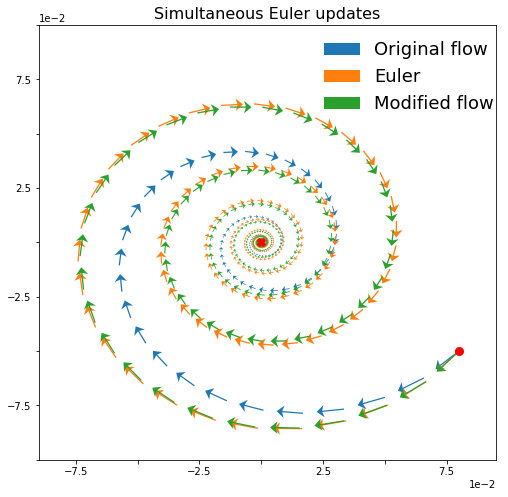

In [ ]:
vect0 = nice_plot_v0
color=['k', 'orange', 'blue', 'gray', 'magenta','orange','orange', 'magenta']
eps1 = 0.2
eps2 = 0.2
lr = 0.2


hw = 10
hl = 6
minshaft = 2
scale = 1.5

color = sns.color_palette("tab10", n_colors=3)

def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]
    
t = np.arange(0, 100, lr)

plot = plt.figure(figsize=(8.2, 8))


# Integrator    
v = vect0[0]
sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
print(sol.shape)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[0], linewidths=widths, edgecolors=color[0], label='Original flow', headwidth=hw, headlength=hl, minshaft=minshaft)  



# Euler
def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]

  

sol = euler(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[1], linewidths=widths, edgecolors=color[1], label='Euler', headwidth=hw, headlength=hl, minshaft=minshaft)    

# Integrator with IGR


def igr_system(t, vect):
  x, y = vect
  return [-eps1 * x + y - lr/ 2 * (eps1 * ( eps1 * x -y) -  eps2 * y - x), -x - eps2 * y - lr /2 * (eps1 * x - y + eps2 ** 2 * y + x * eps2)]
    
 
sol = solve_ivp(igr_system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[2], linewidths=widths, edgecolors=color[2], label='Modified flow', headwidth=hw, headlength=hl, minshaft=minshaft)    



plt.xlim((-0.09, 0.095))
plt.ylim((-0.1, 0.1))


plt.title('Simultaneous Euler updates', size=16)

plt.plot(v[0], v[1], 'ro', markersize=8)
plt.plot(0, 0,'rX', markersize=8) 

n = 2
ax = plt.gca()
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 1]
[l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 1]

plt.legend(loc='upper right', ncol=1, framealpha=0.0, fontsize=18, columnspacing=2.5, bbox_to_anchor=(1.03, 1.))
plt.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))

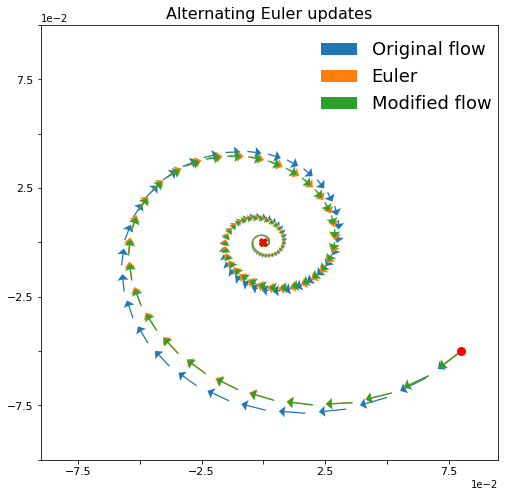

In [ ]:
vect0 = nice_plot_v0

# color=['k', 'red', 'blue', 'gray', 'magenta','orange','orange', 'magenta']
eps1 = 0.2
eps2 = 0.2
hw = 9
hl = 5
lr = 0.2

scale = 1.5

def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]
    
t = np.arange(0, 100, lr)

plot = plt.figure(figsize=(8.2, 8))

# Integrator    
v = vect0[0]
sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T

widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[0], linewidths=widths, edgecolors=color[0], label='Original flow', headwidth=hw)  


# Integrator with IGR
def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]

   
    
v = vect0[0]
sol = euler_alternating(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[1], linewidths=widths, edgecolors=color[1], label='Euler', headwidth=hw)   



def igr_system_alternating(t, vect):
  x, y = vect
  return [-eps1 * x + y - lr/ 2 * (eps1 * ( eps1 * x -y) -  eps2 * y - x), -x - eps2 * y - lr /2 * ( -(2 * lr / lr -1) * (eps1 * x - y) + eps2 ** 2 * y + x * eps2)]


sol = solve_ivp(igr_system_alternating, (0, 100), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[2], linewidths=widths, edgecolors=color[2], label='Modified flow', headwidth=hw)      

plt.xlim((-0.09, 0.095))
plt.ylim((-0.1, 0.1))

plt.title('Alternating Euler updates', size=16)
plt.plot(v[0], v[1], 'ro', markersize=8)
plt.plot(0, 0,'rX', markersize=8) 


n = 2
ax = plt.gca()
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 1]
[l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 1]

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.legend(loc='upper right', ncol=1, framealpha=0.0, fontsize=18, columnspacing=2.5, bbox_to_anchor=(1.02, 1.))
plt.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))

## High rotational field with divergence

(500, 2)


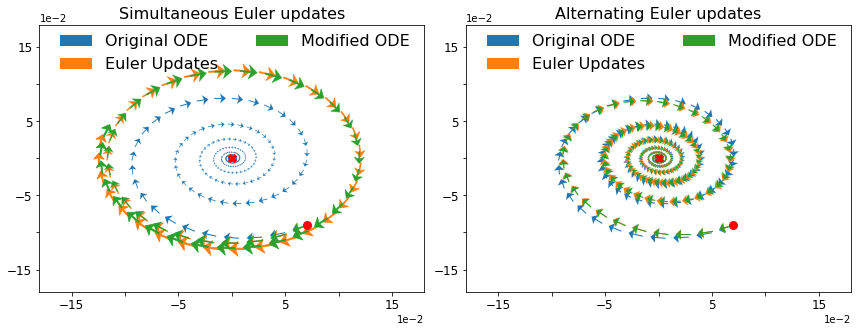

In [ ]:
nice_plot_v0 = [(0.07, -0.09)]
vect0 = nice_plot_v0
color=['k', 'orange', 'blue', 'gray', 'magenta','orange','orange', 'magenta']

eps1 = 0.09
eps2 = 0.09
lr = 0.2

hw = 10
hl = 6
minshaft = 2
scale = 1.5

ORIGINAL_LABEL = 'Original ODE'
MODIFIED_LABEL = 'Modified ODE'

color = sns.color_palette("tab10", n_colors=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.3))
fig.tight_layout()

def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]
    
t = np.arange(0, 100, lr)

# Integrator    
v = vect0[0]
sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
print(sol.shape)
widths = np.linspace(0, 2, sol.size)
ax1.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[0], linewidths=widths, edgecolors=color[0], label=ORIGINAL_LABEL, headwidth=hw, headlength=hl, minshaft=minshaft)  



# Euler
def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]

short_t = np.arange(0, 9, lr)
sol = euler(system, v, short_t)
widths = np.linspace(0, 2, sol.size)
ax1.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[1], linewidths=widths, edgecolors=color[1], label='Euler Updates', headwidth=hw, headlength=hl, minshaft=minshaft)    

def igr_system(t, vect):
  x, y = vect
  return [-eps1 * x + y - lr/ 2 * (eps1 * ( eps1 * x -y) -  eps2 * y - x), -x - eps2 * y - lr /2 * (eps1 * x - y + eps2 ** 2 * y + x * eps2)]
    
 
sol = solve_ivp(igr_system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(short_t).T
widths = np.linspace(0, 2, sol.size)
ax1.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[2], linewidths=widths, edgecolors=color[2], label=MODIFIED_LABEL, headwidth=hw, headlength=hl, minshaft=minshaft)    

ax1.set_xlim((-0.18, 0.18))
ax1.set_ylim((-0.18, 0.18))

ax1.set_title('Simultaneous Euler updates', size=16)

ax1.plot(v[0], v[1], 'ro', markersize=8)
ax1.plot(0, 0,'rX', markersize=8) 

n = 2 
[l.set_visible(False) for (i,l) in enumerate(ax1.xaxis.get_ticklabels()) if i % n != 1]
[l.set_visible(False) for (i,l) in enumerate(ax1.yaxis.get_ticklabels()) if i % n != 1]

ax1.legend(loc='upper right', ncol=2, framealpha=0.0, fontsize=16, columnspacing=2.4, bbox_to_anchor=(1., 1.02))

ax1.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))


def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]
    
t = np.arange(0, 100, lr)

# Integrator    
v = vect0[0]
sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T

widths = np.linspace(0, 2, sol.size)
ax2.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[0], linewidths=widths, edgecolors=color[0], label=ORIGINAL_LABEL, headwidth=hw)  

def system(t, vect):
  x, y = vect
  return [-eps1 * x + y, -x - eps2 * y]
    
v = vect0[0]
sol = euler_alternating(system, v, t)
widths = np.linspace(0, 2, sol.size)
ax2.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[1], linewidths=widths, edgecolors=color[1], label='Euler Updates', headwidth=hw)   

def igr_system_alternating(t, vect):
  x, y = vect
  return [-eps1 * x + y - lr/ 2 * (eps1 * ( eps1 * x -y) -  eps2 * y - x), -x - eps2 * y - lr /2 * ( -(2 * lr / lr -1) * (eps1 * x - y) + eps2 ** 2 * y + x * eps2)]

sol = solve_ivp(igr_system_alternating, (0, 100), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
widths = np.linspace(0, 2, sol.size)
ax2.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=scale, color=color[2], linewidths=widths, edgecolors=color[2], label=MODIFIED_LABEL, headwidth=hw)      

ax2.set_xlim((-0.18, 0.18))
ax2.set_ylim((-0.18, 0.18))

ax2.set_title('Alternating Euler updates', size=16)

ax2.plot(v[0], v[1], 'ro', markersize=8)
ax2.plot(0, 0,'rX', markersize=8) 


n = 2 
[l.set_visible(False) for (i,l) in enumerate(ax2.xaxis.get_ticklabels()) if i % n != 1]
[l.set_visible(False) for (i,l) in enumerate(ax2.yaxis.get_ticklabels()) if i % n != 1]

ax1.tick_params(axis="both", labelsize=12)
ax2.tick_params(axis="both", labelsize=12)

ax2.legend(loc='upper right', ncol=2, framealpha=0.0, fontsize=16, columnspacing=2.4, bbox_to_anchor=(1., 1.02))

ax2.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))

In [ ]:
def is_stable(matrix):
  return np.trace(matrix) < 0 and np.linalg.det(matrix) > 0

sim_jacobian_matrix = np.array([[-eps1 - lr / 2 * eps1**2 + lr /2 , 1 + lr / 2 * eps1 - lr / 2 * eps2], 
                                 [-1 - lr /2 * eps1 + lr /2 * eps2, eps2 + lr / 2 - lr/2 * eps2**2]])
alt_jacobian_matrix = np.array([[-eps1 - lr / 2 * eps1**2 + lr /2, 1 + lr / 2 * eps1 - lr / 2 * eps2], 
                                 [-1 + lr /2 * eps1 + lr /2 * eps2, eps2 - lr / 2 - lr/2 * eps2 **2]])

print(is_stable(sim_jacobian_matrix))
print(np.trace(sim_jacobian_matrix))
print(np.linalg.det(sim_jacobian_matrix))

print(is_stable(alt_jacobian_matrix))
print(np.trace(alt_jacobian_matrix))
print(np.linalg.det(alt_jacobian_matrix))

False
0.19838
1.0017386560999997
True
-0.0016200000000000051
0.9819006560999999


# Dirac GAN

In [ ]:
grad_f = lambda x:  1. / (1 + np.exp(-x))
double_grad_f = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

vect0 = [(1, 1)]

(-3.0, 4.5)

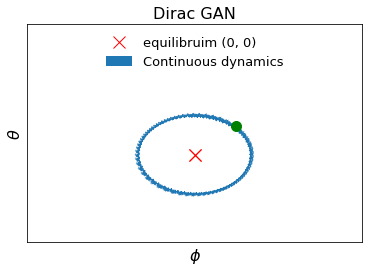

In [ ]:
disc_lr = 0.1
gen_lr = 0.1


def system(t, vect):
  x, y = vect
  return [-grad_f(x * y) * y, grad_f(x * y) * x]

t = np.arange(0, 100, 0.2)
plot = plt.figure()
v = vect0[0]        

sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=2, color=color[0], linewidths=widths, edgecolors=color[0], label='Continuous dynamics', headwidth=hw, headlength=hl, minshaft=2)  

plt.title('Dirac GAN', fontsize=16)
plt.plot(v[0], v[1], 'go', markersize=10)
plt.plot(0, 0,'rx', markersize=12) 
plt.plot(0, 0,'rx', markersize=12, label='equilibruim (0, 0)')  
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 1), fontsize=13, framealpha=0)

plt.xlabel(r'$\phi$', fontsize=16)
plt.ylabel(r'$\theta$', fontsize=16)

plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_46.kernel.colaboratory-playground.1099376611699.14b334fb3717c109/mount/server/notebook.par:2: RuntimeWarning: overflow encountered in double_scalars
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_46.kernel.colaboratory-playground.1099376611699.14b334fb3717c109/mount/server/notebook.par:1: RuntimeWarning: overflow encountered in exp
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_46.kernel.colaboratory-playground.1099376611699.14b334fb3717c109/mount/server/notebook.par:2: RuntimeWarning: overflow encountered in exp
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_46.kernel.colaboratory-playground.1099376611699.14b334fb3717c109/mount/server/notebook.par:2: RuntimeWarning: invalid value encountered in double_scalars


(-3.0, 4.5)

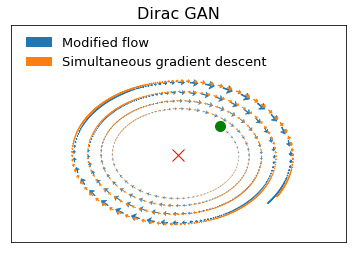

In [ ]:
disc_lr = 0.1
gen_lr = 0.1

def igr_system(t, vect):
  x, y = vect

  y_igr = -2 * y * grad_f(x * y) **2 - 2 * y ** 2 * x * grad_f(x * y) * double_grad_f(x * y)  + 2 * x**3 *  grad_f(x * y) * double_grad_f(x * y)
  x_igr = - 2 * y **3 * grad_f(x * y) * double_grad_f(x * y) + 2 * x * grad_f(x * y) **2 + 2 * x** 2 * y *  grad_f(x * y) * double_grad_f(x * y)
  return [grad_f(x * y) * y + disc_lr/ 4 * x_igr, - grad_f(x * y) * x - gen_lr /4 * y_igr ]
    

t = np.arange(0, 100, 0.2)
plot = plt.figure()
v = vect0[0]        

sol = solve_ivp(igr_system, (0, 200), v, t_eval=t, dense_output=True, method='RK45')
sol = sol.sol(t).T
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=2, color=color[0], linewidths=widths, edgecolors=color[0], label='Modified flow', headwidth=hw, headlength=hl, minshaft=2)  


def system(t, vect):
  x, y = vect
  return [grad_f(x * y) * y, - grad_f(x * y) * x]

t = np.arange(0, 100, 0.1)
    
v = vect0[0]    
sol = euler(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=2, color=color[1], linewidths=widths, edgecolors=color[1], label='Simultaneous gradient descent', headwidth=hw, headlength=hl, minshaft=2)  

plt.title('Dirac GAN', fontsize=16)
plt.plot(v[0], v[1], 'go', markersize=10)
plt.plot(0, 0,'rx', markersize=12) 
plt.legend(loc='upper right', bbox_to_anchor=(0.8, 1), fontsize=13, framealpha=0)


plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

([], [])

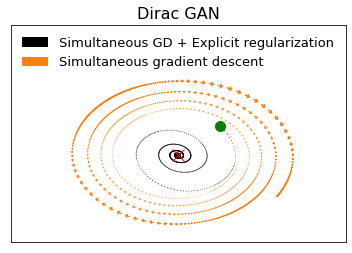

In [ ]:
lr = 0.1

reg_mul = lr / 4 + 0.3

def with_penalty_system(t, vect):
  x, y = vect

  y_egr = 2 * y * grad_f(x * y) **2 + 2 * y ** 2 * x * grad_f(x * y) * double_grad_f(x * y) 
  x_egr = 2 * y **3 * grad_f(x * y) * double_grad_f(x * y) 
  return [grad_f(x * y) * y + reg_mul * x_egr, - grad_f(x * y) * x - reg_mul * y_egr ]


t = np.arange(0, 100, lr)

v = vect0[0]    
sol = euler(with_penalty_system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=2, color='k', linewidths=widths, edgecolors='k', label='Simultaneous GD + Explicit regularization', headwidth=hw, headlength=hl, minshaft=2)  

def system(t, vect):
  x, y = vect
  return [grad_f(x * y) * y, - grad_f(x * y) * x]


v = vect0[0]    
sol = euler(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(sol[:-1, 0], sol[:-1, 1], sol[1:, 0]-sol[:-1, 0], sol[1:, 1]-sol[:-1, 1], scale_units='xy', angles='xy', scale=2, color=color[1], linewidths=widths, edgecolors=color[1], label='Simultaneous gradient descent', headwidth=hw, headlength=hl, minshaft=2) 

plt.title('Dirac GAN', fontsize=16)
plt.plot(v[0], v[1], 'go', markersize=10)
plt.plot(0, 0,'rx', markersize=12) 
plt.legend(loc='upper right', bbox_to_anchor=(1., 1), fontsize=13, framealpha=0)

plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

plt.xticks([])
plt.yticks([])